# ANÁLISE DE VENDAS E-COMMERCE
*PADRÕES DE VENDA E PREVISÃO FUTURA DA EMPRESA OLIST (E-COMMERCE BRASILEIRO)*

In [56]:
#Importando Bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats import f_oneway
from google.colab import files

sns.set(style='whitegrid')

In [57]:
# Carregando datasets
orders = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv', on_bad_lines='skip')
customers = pd.read_csv('olist_customers_dataset.csv')

ANÁLISE PRELIMINAR DOS DATAFRAMES

In [58]:
def analisar_dataframe(df, nome):
    print(f"\n{'='*50}")
    print(f"Análise do DataFrame: {nome}")
    print(f"{'='*50}")
    print(f"Dimensões: {df.shape}")
    print("\nPrimeiras 5 linhas:")
    print(df.head())
    print("\nInformações dos tipos de dados:")
    df.info()
    print("\nValores nulos por coluna:")
    print(df.isnull().sum())
    print(f"{'='*50}\n")

# Análise preliminar dos dataframes
print("Realizando análise preliminar dos dados...")
analisar_dataframe(orders, "Orders")
analisar_dataframe(order_items, "Order Items")
analisar_dataframe(products, "Products")
analisar_dataframe(customers, "Customers")


Realizando análise preliminar dos dados...

Análise do DataFrame: Orders
Dimensões: (99441, 8)

Primeiras 5 linhas:
                           order_id                       customer_id order_status order_purchase_timestamp    order_approved_at order_delivered_carrier_date order_delivered_customer_date  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15          2017-10-04 19:55:00           2017-10-10 21:25:13   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27          2018-07-26 14:31:00           2018-08-07 15:27:45   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23          2018-08-08 13:50:00           2018-08-17 18:06:29   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82    delivered      2017-11-18 19:28:06  2017-11-18 

UNIFICANDO DATASET

In [59]:
# Mesclar datasets
df = pd.merge(orders, order_items, on='order_id', how='inner')
df = pd.merge(df, products, on='product_id', how='left')
df = pd.merge(df, customers, on='customer_id', how='left')

print("\nColunas finais no DataFrame:")
print(list(df.columns))


Colunas finais no DataFrame:
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']


In [61]:
#limpeza e preparação
# Renomear colunas relevantes
df.rename(columns={
    'order_purchase_timestamp': 'Data',
    'product_category_name': 'Categoria',
    'customer_state': 'Estado'
}, inplace=True)

# Converter data
df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'], errors='coerce')

# Criar variáveis derivadas
df['Dia_Semana'] = df['Data'].dt.dayofweek  # 0=segunda, 6=domingo
df['Hora_Dia'] = df['Data'].dt.hour
df['Mes_Ano'] = df['Data'].dt.to_period("M").astype(str)
df['Tempo_Entrega'] = (df['order_delivered_customer_date'] - df['Data']).dt.days
df['Venda_Total'] = df['price'] + df['freight_value']

# Remover valores nulos
df = df.dropna()

# Manter apenas categorias mais comuns
top_categorias = df['Categoria'].value_counts().index[:10]
df = df[df['Categoria'].isin(top_categorias)]

print("\nPreparação concluída!")





Preparação concluída!


In [62]:
#agrupamentos necessários

# Por mês
monthly_sales = df.groupby("Mes_Ano").agg(
    num_orders=("order_id", "nunique"),
    total_sales=("Venda_Total", "sum"),
    avg_delivery_time=("Tempo_Entrega", "mean")
).reset_index()

# Por categoria
category_sales = df.groupby("Categoria").agg(
    num_orders=("order_id", "nunique"),
    total_sales=("Venda_Total", "sum"),
    avg_price=("price", "mean")
).reset_index()

ANÁLISE EXPLORATÓRIA COM GRÁFICOS - PASTA VISUALIZACOES CRIADA PARA ORGANIZAR AS IMAGENS DE TODOS OS GRÁFICOS

In [80]:
import os
import matplotlib.ticker as ticker

VISUALIZACOES_DIR = "visualizacoes"
os.makedirs(VISUALIZACOES_DIR, exist_ok=True)


# 1. Evolução do número de pedidos ao longo do tempo
plt.figure(figsize=(14, 8))
plt.plot(monthly_sales["Mes_Ano"], monthly_sales["num_orders"], marker="o", linestyle="-", linewidth=2)
plt.title("Evolução do Número de Pedidos ao Longo do Tempo", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Número de Pedidos", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZACOES_DIR, "01_evolucao_pedidos.png"))
plt.close()


# 2. Evolução do valor total de vendas ao longo do tempo
plt.figure(figsize=(14, 8))
plt.plot(monthly_sales["Mes_Ano"], monthly_sales["total_sales"], marker="o", linestyle="-", linewidth=2, color="green")
plt.title("Evolução do Valor Total de Vendas ao Longo do Tempo", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Valor Total de Vendas (R$)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("R$ {x:,.0f}"))
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZACOES_DIR, "02_evolucao_valor_vendas.png"))
plt.close()


# 3. Tempo médio de entrega ao longo do tempo
plt.figure(figsize=(14, 8))
plt.plot(monthly_sales["Mes_Ano"], monthly_sales["avg_delivery_time"], marker="o", linestyle="-", linewidth=2, color="orange")
plt.title("Evolução do Tempo Médio de Entrega ao Longo do Tempo", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Tempo Médio de Entrega (dias)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZACOES_DIR, "03_evolucao_tempo_entrega.png"))
plt.close()


# 4. Top 10 categorias por número de pedidos
top_categories_orders = category_sales.sort_values("num_orders", ascending=False).head(10)
plt.figure(figsize=(14, 10))
sns.barplot(x="num_orders", y="Categoria", data=top_categories_orders, palette="viridis")
plt.title("Top 10 Categorias por Número de Pedidos", fontsize=16)
plt.xlabel("Número de Pedidos", fontsize=14)
plt.ylabel("Categoria", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZACOES_DIR, "04_top_categorias_pedidos.png"))
plt.close()


# 5. Top 10 categorias por venda total
top_categories_sales = category_sales.sort_values("total_sales", ascending=False).head(10)
plt.figure(figsize=(14, 10))
ax = sns.barplot(x="total_sales", y="Categoria", data=top_categories_sales, palette="viridis")
plt.title("Top 10 Categorias por Valor Total de Vendas", fontsize=16)
plt.xlabel("Valor Total de Vendas (R$)", fontsize=14)
plt.ylabel("Categoria", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("R$ {x:,.0f}"))
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZACOES_DIR, "05_top_categorias_valor.png"))
plt.close()


# 6. Top 10 categorias com maior preço médio
top_categories_price = category_sales.sort_values("avg_price", ascending=False).head(10)
plt.figure(figsize=(14, 10))
ax = sns.barplot(x="avg_price", y="Categoria", data=top_categories_price, palette="viridis")
plt.title("Top 10 Categorias com Maior Preço Médio", fontsize=16)
plt.xlabel("Preço Médio (R$)", fontsize=14)
plt.ylabel("Categoria", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("R$ {x:,.0f}"))
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZACOES_DIR, "06_top_categorias_preco_medio.png"))
plt.close()


# 7. Número de pedidos por estado do cliente
state_orders = df.groupby("Estado").agg(num_orders=("order_id", "nunique")).reset_index()
state_orders = state_orders.sort_values(by="num_orders", ascending=False)

plt.figure(figsize=(14, 10))
sns.barplot(x="num_orders", y="Estado", data=state_orders, palette="viridis")
plt.title("Número de Pedidos por Estado do Cliente", fontsize=16)
plt.xlabel("Número de Pedidos", fontsize=14)
plt.ylabel("Estado", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZACOES_DIR, "07_pedidos_por_estado.png"))
plt.close()


# 8. Valor total de vendas por estado do cliente
state_sales = df.groupby("Estado").agg(total_sales=("Venda_Total", "sum")).reset_index()
state_sales = state_sales.sort_values(by="total_sales", ascending=False)

plt.figure(figsize=(14, 10))
ax = sns.barplot(x="total_sales", y="Estado", data=state_sales, palette="viridis")
plt.title("Valor Total de Vendas por Estado do Cliente", fontsize=16)
plt.xlabel("Valor Total de Vendas (R$)", fontsize=14)
plt.ylabel("Estado", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("R$ {x:,.0f}"))
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZACOES_DIR, "08_vendas_por_estado.png"))
plt.close()


# 9. Distribuição de preços
plt.figure(figsize=(14, 8))
sns.histplot(df["price"], bins=50, kde=True)
plt.title("Distribuição de Preços dos Produtos", fontsize=16)
plt.xlabel("Preço (R$)", fontsize=14)
plt.ylabel("Frequência", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(0, 1000)
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZACOES_DIR, "09_distribuicao_precos.png"))
plt.close()


# 10. Distribuição do tempo de entrega
plt.figure(figsize=(14, 8))
sns.histplot(df["Tempo_Entrega"], bins=50, kde=True)
plt.title("Distribuição do Tempo de Entrega", fontsize=16)
plt.xlabel("Tempo de Entrega (dias)", fontsize=14)
plt.ylabel("Frequência", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xlim(0, 100)
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZACOES_DIR, "10_distribuicao_tempo_entrega.png"))
plt.close()


# 11. Vendas por dia da semana
weekday_sales = df.groupby("Dia_Semana").agg(num_orders=("order_id", "nunique")).reset_index()
weekday_sales["Dia_Semana"] = weekday_sales["Dia_Semana"].map({
    0: "Seg", 1: "Ter", 2: "Qua", 3: "Qui", 4: "Sex", 5: "Sáb", 6: "Dom"
})

plt.figure(figsize=(14, 8))
sns.barplot(x="Dia_Semana", y="num_orders", data=weekday_sales, palette="viridis")
plt.title("Número de Pedidos por Dia da Semana", fontsize=16)
plt.xlabel("Dia da Semana", fontsize=14)
plt.ylabel("Número de Pedidos", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZACOES_DIR, "11_pedidos_dia_semana.png"))
plt.close()


# 12. Vendas por hora do dia
hourly_sales = df.groupby("Hora_Dia").agg(num_orders=("order_id", "nunique")).reset_index()

plt.figure(figsize=(14, 8))
sns.barplot(x="Hora_Dia", y="num_orders", data=hourly_sales, palette="viridis")
plt.title("Número de Pedidos por Hora do Dia", fontsize=16)
plt.xlabel("Hora do Dia", fontsize=14)
plt.ylabel("Número de Pedidos", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZACOES_DIR, "12_pedidos_hora_dia.png"))
plt.close()


# 13. Vendas por mês do ano
monthly_pattern = df.groupby("Mes_Ano").agg(num_orders=("order_id", "nunique")).reset_index()

plt.figure(figsize=(14, 8))
sns.barplot(x="Mes_Ano", y="num_orders", data=monthly_pattern, palette="viridis")
plt.title("Número de Pedidos por Mês do Ano", fontsize=16)
plt.xlabel("Mês", fontsize=14)
plt.ylabel("Número de Pedidos", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZACOES_DIR, "13_pedidos_mes_ano.png"))
plt.close()

<ipython-input-80-ecc384f4a95a>:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="num_orders", y="Categoria", data=top_categories_orders, palette="viridis")
<ipython-input-80-ecc384f4a95a>:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="total_sales", y="Categoria", data=top_categories_sales, palette="viridis")
<ipython-input-80-ecc384f4a95a>:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="avg_price", y="Categoria", data=top_categories_price, palette="viridis")
<ipython-input-80-ecc384f4a95a>:94: FutureWarning: 

Passin

TESTES ESTATISTICOS - ANOVA E KRUSKAL-WALLIS

In [81]:
#teste ANOVA diferenças das categorias

from scipy.stats import f_oneway

#Para filtrar amostras das 5 categorias mais vendidas
top_categorias = df['Categoria'].value_counts().index[:5]
amostras_preco_categoria = [df[df['Categoria'] == cat]['price'] for cat in top_categorias]
amostras_tempo_categoria = [df[df['Categoria'] == cat]['Tempo_Entrega'] for cat in top_categorias]

#ANOVA para preço por categoria
f_price, p_price = f_oneway(*amostras_preco_categoria)
print(f'ANOVA - Preço por Categoria: F-statistic={f_price:.2f}, p-valor={p_price:.4f}')
if p_price < 0.05:
    print("Há diferença significativa nos preços entre as categorias.")
else:
    print("Não há evidência suficiente de diferença.")

#ANOVA para tempo de entrega por categoria
f_time, p_time = f_oneway(*amostras_tempo_categoria)
print(f'ANOVA - Tempo de Entrega por Categoria: F-statistic={f_time:.2f}, p-valor={p_time:.4f}')
if p_time < 0.05:
    print("Há diferença significativa no tempo de entrega entre as categorias.")
else:
    print("Não há evidência suficiente de diferença.")

ANOVA - Preço por Categoria: F-statistic=142.99, p-valor=0.0000
Há diferença significativa nos preços entre as categorias.
ANOVA - Tempo de Entrega por Categoria: F-statistic=27.25, p-valor=0.0000
Há diferença significativa no tempo de entrega entre as categorias.


In [82]:
#Teste ANOVA diferenças regionais

# pARA Filtrar amostras dos 5 estados mais frequentes
top_estados = df['Estado'].value_counts().index[:5]
amostras_preco_estado = [df[df['Estado'] == estado]['price'] for estado in top_estados]
amostras_tempo_estado = [df[df['Estado'] == estado]['Tempo_Entrega'] for estado in top_estados]

# ANOVA para preço por estado
f_price_estado, p_price_estado = f_oneway(*amostras_preco_estado)
print(f'\nANOVA - Preço por Estado: F-statistic={f_price_estado:.2f}, p-valor={p_price_estado:.4f}')
if p_price_estado < 0.05:
    print("Há diferença significativa nos preços entre os estados.")
else:
    print("Não há evidência suficiente de diferença.")

# ANOVA para tempo de entrega por estado
f_time_estado, p_time_estado = f_oneway(*amostras_tempo_estado)
print(f'ANOVA - Tempo de Entrega por Estado: F-statistic={f_time_estado:.2f}, p-valor={p_time_estado:.4f}')
if p_time_estado < 0.05:
    print("Há diferença significativa no tempo de entrega entre os estados.")
else:
    print("Não há evidência suficiente de diferença.")


ANOVA - Preço por Estado: F-statistic=18.51, p-valor=0.0000
Há diferença significativa nos preços entre os estados.
ANOVA - Tempo de Entrega por Estado: F-statistic=1589.53, p-valor=0.0000
Há diferença significativa no tempo de entrega entre os estados.


In [83]:
#Teste Kruskal-Wallis

from scipy.stats import kruskal

#Criar variável 'Mes' a partir da data
df['Mes'] = df['Data'].dt.month

#Filtrar amostras por mês
meses = sorted(df['Mes'].unique())
amostras_venda_mes = [df[df['Mes'] == mes]['Venda_Total'] for mes in meses]

#Aplicar Kruskal-Wallis
h_stat, p_val_h = kruskal(*amostras_venda_mes)

print(f'\nKruskal-Wallis - Sazonalidade nas Vendas: H-statistic={h_stat:.2f}, p-valor={p_val_h:.4f}')
if p_val_h < 0.05:
    print("Há evidência estatística de sazonalidade nas vendas.")
else:
    print("Não há evidência de sazonalidade.")


Kruskal-Wallis - Sazonalidade nas Vendas: H-statistic=39.19, p-valor=0.0000
Há evidência estatística de sazonalidade nas vendas.


<ipython-input-84-90ca0d1aa0ce>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Categoria', y='Tempo_Entrega', data=df_top_categoria, palette="viridis")


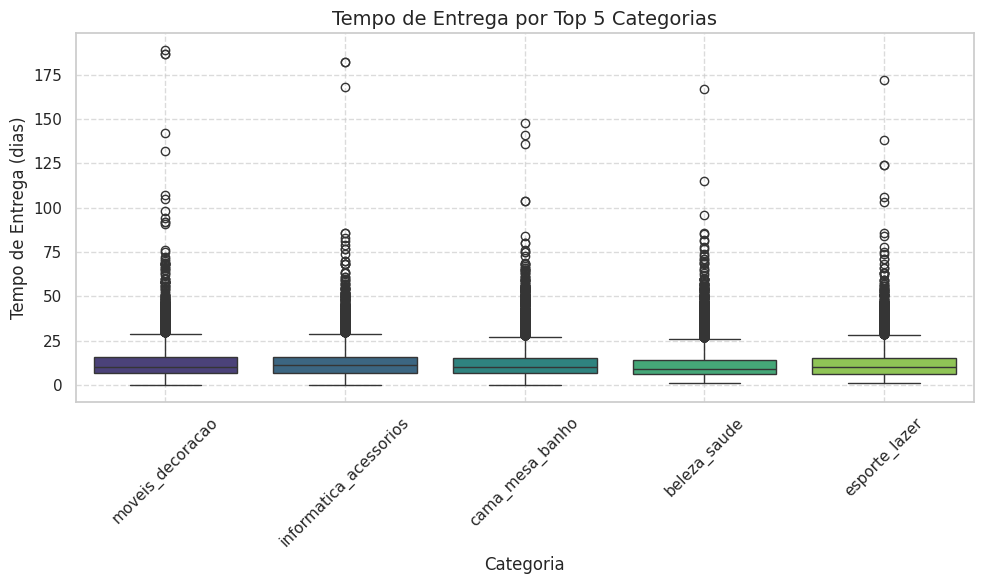

<ipython-input-84-90ca0d1aa0ce>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Estado', y='Tempo_Entrega', data=df_top_estado, palette="viridis")


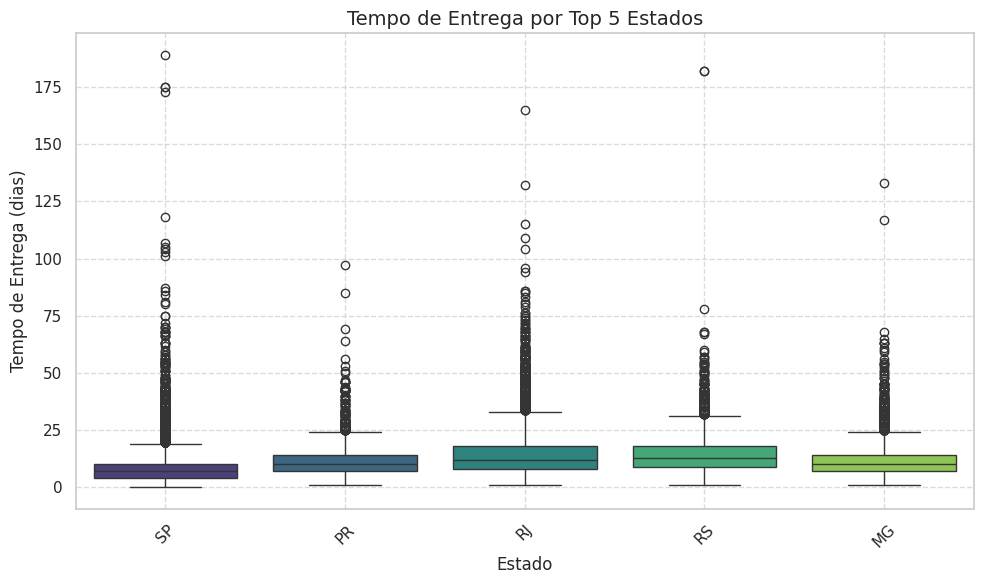

In [84]:
#Box splots

# Selecionar top 5 categorias com mais vendas
top_categorias = df['Categoria'].value_counts().index[:5]
df_top_categoria = df[df['Categoria'].isin(top_categorias)]

# Plotar boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Categoria', y='Tempo_Entrega', data=df_top_categoria, palette="viridis")
plt.title('Tempo de Entrega por Top 5 Categorias', fontsize=14)
plt.xlabel('Categoria')
plt.ylabel('Tempo de Entrega (dias)')
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZACOES_DIR, "14_boxplot_tempo_entrega_top5_categoria.png"))
plt.show()

# Selecionar top 5 estados com mais vendas
top_estados = df['Estado'].value_counts().index[:5]
df_top_estado = df[df['Estado'].isin(top_estados)]

# Plotar boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Estado', y='Tempo_Entrega', data=df_top_estado, palette="viridis")
plt.title('Tempo de Entrega por Top 5 Estados', fontsize=14)
plt.xlabel('Estado')
plt.ylabel('Tempo de Entrega (dias)')
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZACOES_DIR, "15_boxplot_tempo_entrega_top5_estado.png"))
plt.show()

MODELO DE MACHINE LEARNINIG - ARVORE DE DECISÃO

In [89]:
#modelo de machine learning (random forest)

# Features e target
X = df[['Categoria', 'Estado', 'price']]
y = df['Venda_Total']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Pré-processador para variáveis categóricas
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), ['Categoria', 'Estado'])],
    remainder='passthrough'
)

# Definir o modelo com hiperparâmetros ajustados
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1
    ))
])

# Treinar o modelo com novos parâmetros
model.fit(X_train, y_train)

# Predição
y_pred = model.predict(X_test)

# Avaliação
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n Resultados do Modelo Ajustado:")
print(f"- RMSE: R$ {rmse:.2f}")
print(f"- MAE: R$ {mae:.2f}")
print(f"- R²: {r2:.2f}")


 Resultados do Modelo Ajustado:
- RMSE: R$ 29.94
- MAE: R$ 6.26
- R²: 0.97


CROSS VALIDATION OU VALIDAÇÃO CRUSADA - GARANTINDO QUE NÃO HAJA OVERFITING

In [90]:
# Validação cruzada
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("\n Validação Cruzada (R²):")
print(f"- Média: {np.mean(cv_scores):.2f}")
print(f"- Desvio padrão: {np.std(cv_scores):.2f}")
print(f"- Scores por fold: {np.round(cv_scores, 2)}")


 Validação Cruzada (R²):
- Média: 0.99
- Desvio padrão: 0.01
- Scores por fold: [0.99 0.96 0.99 0.99 0.99]


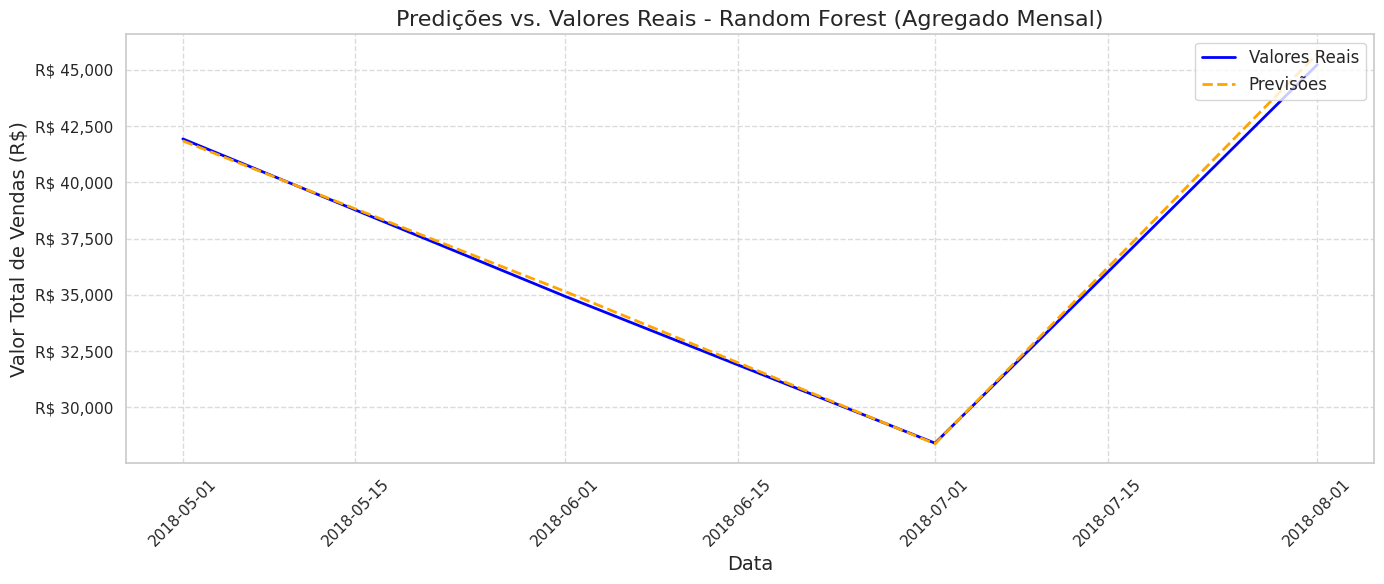

In [91]:
import matplotlib.ticker as ticker

# Adicionar as previsões ao DataFrame
df_test = X_test.copy()
df_test['Venda_Real'] = y_test
df_test['Venda_Prevista'] = y_pred

# Garantir que a coluna 'Data' esteja presente no df_test
df_test['Data'] = df.loc[y_test.index, 'Data'].reset_index(drop=True)

# Filtrar apenas o período de maio a agosto de 2018
start_date = pd.to_datetime('2018-05-01')
end_date = pd.to_datetime('2018-08-31')
df_test_filtered = df_test[(df_test['Data'] >= start_date) & (df_test['Data'] <= end_date)]

# Agrupar por mês
monthly_real = df_test_filtered.groupby(df_test_filtered['Data'].dt.to_period('M'))['Venda_Real'].sum().reset_index()
monthly_pred = df_test_filtered.groupby(df_test_filtered['Data'].dt.to_period('M'))['Venda_Prevista'].sum().reset_index()

# Mesclar real e previsto
monthly_comparison = pd.merge(monthly_real, monthly_pred, on='Data')

# Converter Data de volta para datetime para plotagem
monthly_comparison['Data'] = monthly_comparison['Data'].astype(str).str[:7]  # Manter apenas ano-mês
monthly_comparison['Data'] = pd.to_datetime(monthly_comparison['Data'], format='%Y-%m')

# Plotar gráfico
plt.figure(figsize=(14, 6))
sns.lineplot(x='Data', y='Venda_Real', data=monthly_comparison, label='Valores Reais', color='blue', linewidth=2)
sns.lineplot(x='Data', y='Venda_Prevista', data=monthly_comparison, label='Previsões', linestyle='--', color='orange', linewidth=2)

# Configurar título e eixos
plt.title("Predições vs. Valores Reais - Random Forest (Agregado Mensal)", fontsize=16)
plt.xlabel("Data", fontsize=14)
plt.ylabel("Valor Total de Vendas (R$)", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)

# Formatar eixo Y em R$
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("R$ {x:,.0f}"))

# Legendas
plt.legend(fontsize=12, loc='upper right')

# Salvar e exibir
plt.tight_layout()
plt.savefig(os.path.join(VISUALIZACOES_DIR, "16_real_vs_previsto_mensal.png"))
plt.show()

# PRINCIPAIS CONCLUSÕES


*   TENDENCIA DE CRESCIMENTO E SAZONALIDADE CONFIRMADAS
*   DIFERENÇAS SIGNIFICATIVAS ENTRE CATEGORIAS E ESTADOS (PREÇA E ENTREGA)
*   TEMPO DE ENTREGA VARIA E PODE INDICAR GARGALOS LOGISTICOS
*   MODELO RANDOM FOREST OFERECE UMA BOA PREVISÃO COM R²: 0.97



# PRINCIPAIS RECOMENDAÇÕES



*   Logística: Investigar causas das variações no tempo
de entrega.
* Produtos: Balancear foco entre categorias de volume e valor.
* Regional: Adaptar estratégias de marketing/vendas por estado.
* Previsão: O modelo está bem preparado
* Sazonalidade: Manter planejamento para picos de demanda.

